<a href="https://colab.research.google.com/github/kazars24/dls-mipt-2023/blob/main/homework_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Generative adversarial networks</b></h3>



В этом домашнем задании вы обучите GAN генерировать лица людей и посмотрите на то, как можно оценивать качество генерации

In [ ]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt
import torch
import torch.nn as nn
import cv2
from tqdm.notebook import tqdm
from torchvision.utils import save_image
from torchvision.utils import make_grid
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set(style='darkgrid', font_scale=1.2)

## Часть 1. Подготовка данных (1 балл)

В качестве обучающей выборки возьмем часть датасета [Flickr Faces](https://github.com/NVlabs/ffhq-dataset), который содержит изображения лиц людей в высоком разрешении (1024х1024). Оригинальный датасет очень большой, поэтому мы возьмем его часть. Скачать датасет можно [здесь](https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small?resource=download-directory) и  [здесь](https://drive.google.com/drive/folders/14H7LQWzd09SaM11oLfGtd455sWH2rmRW?usp=share_link)

In [ ]:
!pip install -q kaggle

from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

!kaggle datasets download -d tommykamaz/faces-dataset-small

Saving kaggle.json to kaggle.json
100% 3.99G/3.99G [03:08<00:00, 19.7MB/s]
100% 3.99G/3.99G [03:08<00:00, 22.7MB/s]


In [ ]:
!mkdir -p /content/faces_dataset
!unzip /content/faces-dataset-small.zip -d /content/faces_dataset/

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

Давайте загрузим наши изображения. Напишите функцию, которая строит DataLoader для изображений, при этом меняя их размер до нужного значения (размер 1024 слишком большой, поэтому мы рекомендуем взять размер 128 либо немного больше)

In [ ]:
def get_dataloader(image_size, batch_size):
  """
  Builds dataloader for training data.
  Use tt.Compose and tt.Resize for transformations
  :param image_size: height and wdith of the image
  :param batch_size: batch_size of the dataloader
  :returns: DataLoader object
  """
  # TODO: resize images, convert them to tensors and build dataloader
  transforms_ = tt.Compose([tt.Resize(image_size),
                            tt.ToTensor(),
                            tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
  dataset = ImageFolder("/content/faces_dataset/", transform=transforms_)
  dataloader = DataLoader(dataset, batch_size, shuffle=True, num_workers=2, pin_memory=True)

  return dataloader

In [ ]:
image_size = 128
batch_size = 64

#TODO: build dataloader and transfer it to device
train_dl = get_dataloader(image_size, batch_size)

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

## Часть 2. Построение и обучение модели (2 балла)

Сконструируйте генератор и дискриминатор. Помните, что:
* дискриминатор принимает на вход изображение (тензор размера `3 x image_size x image_size`) и выдает вероятность того, что изображение настоящее (тензор размера 1)

* генератор принимает на вход тензор шумов размера `latent_size x 1 x 1` и генерирует изображение размера `3 x image_size x image_size`

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 128 x 128

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 64 x 64

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 32 x 32

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 16 x 16

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 8 x 8

    nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 1 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
latent_size = 128 # choose latent size

generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 8 x 8

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x16 x 16

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 32 x 32

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 64 x 64

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 128 x 128
)

In [ ]:
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.cpu().detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images.cpu(), nmax)
        break

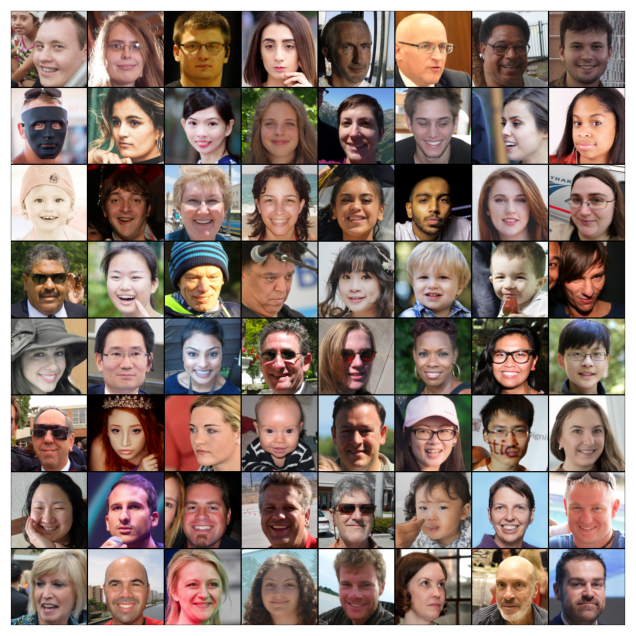

In [ ]:
show_batch(train_dl)

Перейдем теперь к обучению нашего GANа. Алгоритм обучения следующий:
1. Учим дискриминатор:
  * берем реальные изображения и присваиваем им метку 1
  * генерируем изображения генератором и присваиваем им метку 0
  * обучаем классификатор на два класса

2. Учим генератор:
  * генерируем изображения генератором и присваиваем им метку 0
  * предсказываем дискриминаторором, реальное это изображение или нет


В качестве функции потерь берем бинарную кросс-энтропию

In [ ]:
lr = 0.0001

model = {
    "discriminator": discriminator.to(device),
    "generator": generator.to(device)
}

criterion = {
    "discriminator": nn.BCELoss(),
    "generator": nn.BCELoss()
}

In [ ]:
def fit(model, criterion, epochs, lr):
    model["discriminator"].train()
    model["generator"].train()
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    optimizer = {
        "discriminator": torch.optim.Adam(model["discriminator"].parameters(),
                                          lr=lr, betas=(0.5, 0.999)),
        "generator": torch.optim.Adam(model["generator"].parameters(),
                                      lr=lr, betas=(0.5, 0.999))
    }

    for epoch in range(epochs):
        loss_d_per_epoch = []
        loss_g_per_epoch = []
        real_score_per_epoch = []
        fake_score_per_epoch = []
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            # Clear discriminator gradients
            optimizer["discriminator"].zero_grad()

            # Pass real images through discriminator
            real_preds = model["discriminator"](real_images)
            real_targets = torch.ones(real_images.size(0), 1, device=device)
            real_loss = criterion["discriminator"](real_preds, real_targets)
            cur_real_score = torch.mean(real_preds).item()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Pass fake images through discriminator
            fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
            fake_preds = model["discriminator"](fake_images)
            fake_loss = criterion["discriminator"](fake_preds, fake_targets)
            cur_fake_score = torch.mean(fake_preds).item()

            real_score_per_epoch.append(cur_real_score)
            fake_score_per_epoch.append(cur_fake_score)

            # Update discriminator weights
            loss_d = real_loss + fake_loss
            loss_d.backward()
            optimizer["discriminator"].step()
            loss_d_per_epoch.append(loss_d.item())


            # Train generator
            # Clear generator gradients
            optimizer["generator"].zero_grad()

            # Generate fake images
            latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
            fake_images = model["generator"](latent)

            # Try to fool the discriminator
            preds = model["discriminator"](fake_images)
            targets = torch.ones(batch_size, 1, device=device)
            loss_g = criterion["generator"](preds, targets)

            # Update generator weights
            loss_g.backward()
            optimizer["generator"].step()
            loss_g_per_epoch.append(loss_g.item())

        # Record losses & scores
        losses_g.append(np.mean(loss_g_per_epoch))
        losses_d.append(np.mean(loss_d_per_epoch))
        real_scores.append(np.mean(real_score_per_epoch))
        fake_scores.append(np.mean(fake_score_per_epoch))

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs,
            losses_g[-1], losses_d[-1], real_scores[-1], fake_scores[-1]))

    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
history = fit(model, criterion, 20, lr)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/20], loss_g: 9.8637, loss_d: 0.2711, real_score: 0.9294, fake_score: 0.1152


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [2/20], loss_g: 11.1870, loss_d: 0.3897, real_score: 0.9457, fake_score: 0.0952


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [3/20], loss_g: 8.9632, loss_d: 0.1935, real_score: 0.9337, fake_score: 0.0805


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [4/20], loss_g: 9.7981, loss_d: 0.2077, real_score: 0.9372, fake_score: 0.0715


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [5/20], loss_g: 9.0885, loss_d: 0.1176, real_score: 0.9544, fake_score: 0.0496


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [6/20], loss_g: 10.1873, loss_d: 0.2154, real_score: 0.9396, fake_score: 0.0621


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [7/20], loss_g: 10.5893, loss_d: 0.1265, real_score: 0.9591, fake_score: 0.0388


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [8/20], loss_g: 8.6692, loss_d: 0.0424, real_score: 0.9838, fake_score: 0.0224


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [9/20], loss_g: 6.3533, loss_d: 0.0393, real_score: 0.9785, fake_score: 0.0160


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [10/20], loss_g: 6.3105, loss_d: 0.0224, real_score: 0.9878, fake_score: 0.0094


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [11/20], loss_g: 6.0056, loss_d: 0.0132, real_score: 0.9924, fake_score: 0.0054


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [12/20], loss_g: 6.0726, loss_d: 0.0097, real_score: 0.9949, fake_score: 0.0044


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [13/20], loss_g: 6.4280, loss_d: 0.0120, real_score: 0.9935, fake_score: 0.0053


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [14/20], loss_g: 6.2916, loss_d: 0.0090, real_score: 0.9950, fake_score: 0.0038


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [15/20], loss_g: 6.6449, loss_d: 0.0055, real_score: 0.9968, fake_score: 0.0023


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [16/20], loss_g: 6.7305, loss_d: 0.0070, real_score: 0.9954, fake_score: 0.0019


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [17/20], loss_g: 8.9824, loss_d: 0.5574, real_score: 0.9177, fake_score: 0.0443


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [18/20], loss_g: 7.2823, loss_d: 0.0712, real_score: 0.9700, fake_score: 0.0314


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [19/20], loss_g: 4.5360, loss_d: 0.6965, real_score: 0.8310, fake_score: 0.1323


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [20/20], loss_g: 3.8260, loss_d: 0.3259, real_score: 0.8888, fake_score: 0.0963


In [ ]:
torch.save({
            'discriminator_state_dict': model["discriminator"].state_dict(),
            'generator_state_dict': model["generator"].state_dict()
           }, 'gan_model.pth')

Постройте графики лосса для генератора и дискриминатора. Что вы можете сказать про эти графики?

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

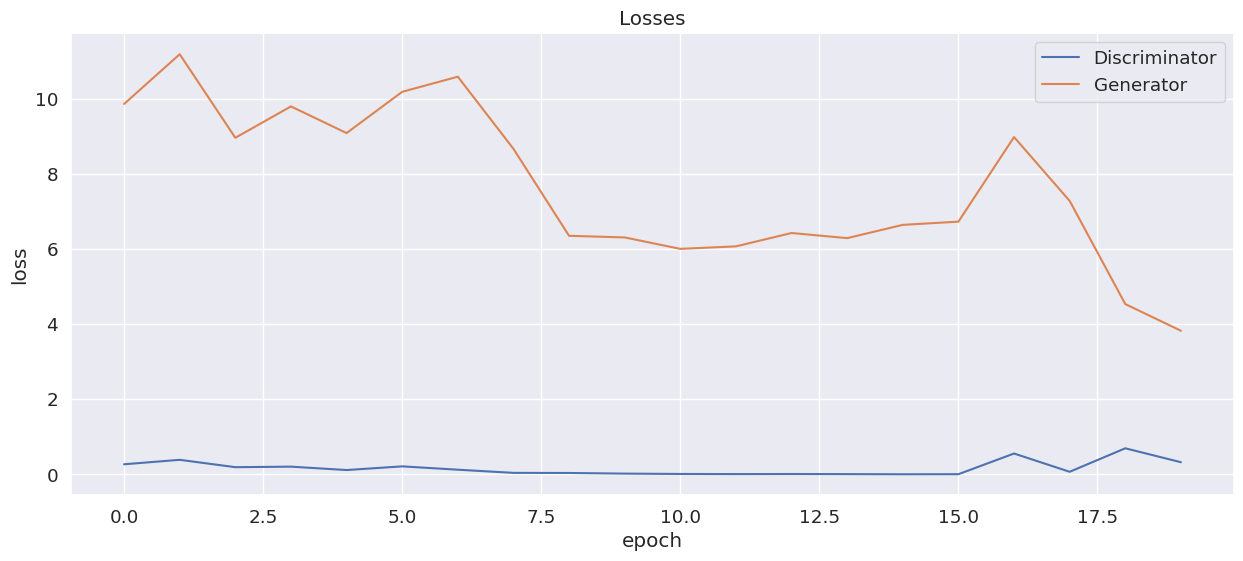

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Часть 3. Генерация изображений (1 балл)

Теперь давайте оценим качество получившихся изображений. Напишите функцию, которая выводит изображения, сгенерированные нашим генератором

In [ ]:
n_images = 4

fixed_latent = torch.randn(n_images, latent_size, 1, 1, device=device)
fake_images = model["generator"](fixed_latent)

функцию я уже написал выше. Применим ее.

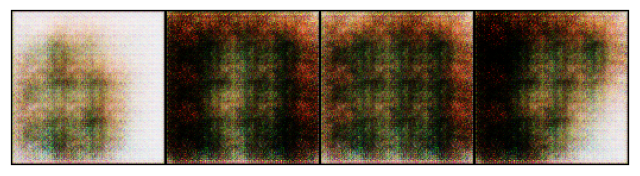

In [ ]:
show_images(fake_images, nmax=4)

Как вам качество получившихся изображений?

## Часть 4. Leave-one-out-1-NN classifier accuracy (6 баллов)

### 4.1. Подсчет accuracy (4 балла)

Не всегда бывает удобно оценивать качество сгенерированных картинок глазами. В качестве альтернативы вам предлагается реализовать следующий подход:
  * Сгенерировать столько же фейковых изображений, сколько есть настоящих в обучающей выборке. Присвоить фейковым метку класса 0, настоящим – 1.
  * Построить leave-one-out оценку: обучить 1NN Classifier (`sklearn.neighbors.KNeighborsClassifier(n_neighbors=1)`) предсказывать класс на всех объектах, кроме одного, проверить качество (accuracy) на оставшемся объекте. В этом вам поможет `sklearn.model_selection.LeaveOneOut`

In [ ]:
model = {
    "discriminator": discriminator,
    "generator": generator
}

checkpoint = torch.load('/content/gan_model.pth')
model['discriminator'].load_state_dict(checkpoint['discriminator_state_dict'])
model['generator'].load_state_dict(checkpoint['generator_state_dict'])

<All keys matched successfully>

In [ ]:
from sklearn.model_selection import LeaveOneOut
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [ ]:
transforms_ = tt.Compose([tt.Resize(image_size),
                            tt.ToTensor(),
                            tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
true_faces = ImageFolder("/content/faces_dataset/", transform=transforms_)

In [ ]:
torch.cuda.empty_cache()

In [ ]:
cv = LeaveOneOut()
knn = KNeighborsClassifier(n_neighbors=1)

fixed_latent = torch.randn(len(true_faces), latent_size, 1, 1).to(device)
fake_images = model["generator"].to(device)(fixed_latent)
fake_labels = torch.zeros(fake_images.size(0), 1)

true_labels = torch.ones(len(true_faces), 1)

all_labels = torch.cat((fake_labels, true_labels))
true_images = []
for img, _ in tqdm(true_faces):
    true_images.append(img)

  0%|          | 0/3143 [00:00<?, ?it/s]

In [ ]:
all_imgs = torch.cat((fake_images.cpu(), torch.stack(true_images).cpu()))

scores = cross_val_score(knn, all_imgs, all_labels, scoring='accuracy', cv=cv, n_jobs=-1, verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Что вы можете сказать о получившемся результате? Какой accuracy мы хотели бы получить и почему?

### 4.2. Визуализация распределений (2 балла)

Давайте посмотрим на то, насколько похожи распределения настоящих и фейковых изображений. Для этого воспользуйтесь методом, снижающим размерность (к примеру, TSNE) и изобразите на графике разным цветом точки, соответствующие реальным и сгенерированным изображенияи

Прокомментируйте получившийся результат: